In [1]:
import os
import re
import ast
import importlib

from dotenv import load_dotenv
from typing import Dict, List, Any, Optional, Annotated, Union, Literal
from typing_extensions import TypedDict
from enum import Enum

from langchain_openai import ChatOpenAI
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage, filter_messages
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition, ToolNode

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.errors import NodeInterrupt

from IPython.display import Image, display

from langchain_core.prompts import ChatPromptTemplate

In [2]:
load_dotenv()

True

In [3]:
db = SQLDatabase.from_uri("sqlite:///../sql-support-bot/chinook.db")
print(db.get_usable_table_names())

['albums', 'artists', 'customers', 'employees', 'genres', 'invoice_items', 'invoices', 'media_types', 'playlist_track', 'playlists', 'tracks']


In [4]:
os.environ["LANGCHAIN_PROJECT"] = "music-store-support-demo-prep"

# Set up LLMs, state and interrupt messages

In [5]:
helpdesk_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
account_agent_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
music_recommendation_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

In [6]:
class NodeType(str, Enum):
    ROUTER = "router"
    QUERY = "query"
    UPDATE = "update"
    HUMAN_APPROVAL = "human_approval"
    RESPONSE = "response"

class MusicStoreChatbotState(MessagesState):
    customer_id: Optional[int]
    next_node: NodeType
    approved: Optional[bool]

In [7]:
customer_id_interrupt_message = "Please provide your customer ID to help me assist you better."
action_confirmation_interrupt_message = "This action will update the database. Please confirm that you want to proceed (yes/no)"

# Helper Functions

In [8]:
def get_last_human_message(messages: List[BaseMessage]) -> Optional[HumanMessage]:
    """Extract the last human message from the conversation history."""
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            return message
    return None

# Account Agent

## Set up graph

### Tools

#### Tools for customer profile

In [9]:
@tool
def query_customer_info(customer_id: int):
    """Look up customer info given their ID. Requires customer authentication."""
    return db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")

@tool
def update_customer_info(customer_id: int, field: str, value: str) -> str:
    """
    Update a customer's information.
    - customer_id: The ID of the customer to update
    - field: The field to update (FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Email)
    - value: The new value for the field
    - confirmed: Has the user confirmed that they want to proceed?
    """
    allowed_fields = ["FirstName", "LastName", "Company", "Address", "City", 
                       "State", "Country", "PostalCode", "Phone", "Email"]

    if field not in allowed_fields:
        return f"Error: Cannot update field '{field}'. Allowed fields are: {', '.join(allowed_fields)}"

    # Verify customer exists first
    customer = db.run(f"SELECT * FROM customers WHERE CustomerId = {customer_id};")
    if not customer:
        return f"Error: No customer found with ID {customer_id}"

    try:
        # Sanitize the value to prevent SQL injection
        sanitized_value = value.replace("'", "''")  # Double up single quotes for SQL safety
        
        # Execute the actual update query
        update_query = f"UPDATE customers SET {field} = '{sanitized_value}' WHERE CustomerId = {customer_id};"
        db.run(update_query)
        
        # Simply assume success if no exceptions occurred
        return f"Successfully updated {field} to '{value}' for customer {customer_id}"
    
    except Exception as e:
        return f"Error updating database: {str(e)}"

#### Tools for customer transactions

In [10]:
@tool
def get_customer_invoices(customer_id: int, limit: int = 10):
    """Retrieve the most recent invoices for a customer."""
    return db.run(f"""
        SELECT InvoiceId, InvoiceDate, Total 
        FROM invoices 
        WHERE CustomerId = {customer_id}
        ORDER BY InvoiceDate DESC
        LIMIT {limit};
    """, include_columns=True)

@tool
def get_invoice_details(invoice_id: int):
    """Get detailed line items for a specific invoice."""
    return db.run(f"""
        SELECT ii.InvoiceLineId, t.Name as TrackName, 
               ar.Name as ArtistName, al.Title as AlbumTitle,
               ii.UnitPrice, ii.Quantity
        FROM invoice_items ii
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE ii.InvoiceId = {invoice_id}
        ORDER BY ii.InvoiceLineId;
    """, include_columns=True)

@tool
def get_spending_history(customer_id: int, start_date: str = None, end_date: str = None):
    """Get a customer's spending history, optionally within a date range."""
    date_filter = ""
    if start_date and end_date:
        date_filter = f"AND InvoiceDate BETWEEN '{start_date}' AND '{end_date}'"
    elif start_date:
        date_filter = f"AND InvoiceDate >= '{start_date}'"
    elif end_date:
        date_filter = f"AND InvoiceDate <= '{end_date}'"
    
    return db.run(f"""
        SELECT strftime('%Y-%m', InvoiceDate) as Month, 
               SUM(Total) as MonthlyTotal,
               COUNT(InvoiceId) as PurchaseCount
        FROM invoices
        WHERE CustomerId = {customer_id} {date_filter}
        GROUP BY strftime('%Y-%m', InvoiceDate)
        ORDER BY Month DESC;
    """, include_columns=True)

@tool
def get_recent_purchases(customer_id: int, limit: int = 5):
    """Get the most recent purchases for quick reference."""
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist,
               ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE i.CustomerId = {customer_id}
        ORDER BY i.InvoiceDate DESC
        LIMIT {limit};
    """
    return db.run(query, include_columns=True)


@tool
def check_purchase_history(customer_id: int, date_from: str = None, date_to: str = None, 
                          track_name: str = None, artist_name: str = None, album_title: str = None):
    """
    Check purchase history with flexible filtering options.
    Provide at least one filter parameter (date range, track, artist, or album).
    """
    # Build WHERE clause based on provided parameters
    filters = [f"i.CustomerId = {customer_id}"]
    
    if date_from:
        filters.append(f"i.InvoiceDate >= '{date_from}'")
    if date_to:
        filters.append(f"i.InvoiceDate <= '{date_to}'")
        
    # Use retrievers for fuzzy matching where appropriate
    track_filter = ""
    if track_name:
        docs = song_retriever.get_relevant_documents(track_name)
        if docs:
            track_ids = ", ".join([str(doc.metadata['TrackId']) for doc in docs[:5]])
            filters.append(f"t.TrackId IN ({track_ids})")
    
    artist_filter = ""
    if artist_name:
        docs = artist_retriever.get_relevant_documents(artist_name)
        if docs:
            artist_ids = ", ".join([str(doc.metadata['ArtistId']) for doc in docs[:5]])
            filters.append(f"ar.ArtistId IN ({artist_ids})")
    
    if album_title:
        filters.append(f"al.Title LIKE '%{album_title}%'")
    
    where_clause = " AND ".join(filters)
    
    query = f"""
        SELECT i.InvoiceDate, t.Name as TrackName, ar.Name as Artist, 
               al.Title as Album, ii.UnitPrice
        FROM invoices i
        JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId
        JOIN tracks t ON ii.TrackId = t.TrackId
        JOIN albums al ON t.AlbumId = al.AlbumId
        JOIN artists ar ON al.ArtistId = ar.ArtistId
        WHERE {where_clause}
        ORDER BY i.InvoiceDate DESC
        LIMIT 20;
    """
    
    return db.run(query, include_columns=True)

In [11]:
account_query_tools = [
    query_customer_info, 
    get_customer_invoices, 
    get_invoice_details, 
    get_spending_history, 
    get_recent_purchases, 
    check_purchase_history
]
account_update_tools = [update_customer_info]

In [12]:
# account_agent_model_with_tools = account_agent_model.bind_tools(tools=account_query_tools + account_update_tools)
tools_dict = {tool.name: tool for tool in account_query_tools + account_update_tools}

### Node: Router

In [ ]:
account_agent_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Determine if the customer request requires:
1. QUERY operations (retrieving information only)
2. UPDATE operations (making changes to customer data or purchases)

Customer ID: {customer_id}
Customer request: {input}

Respond with just one word: QUERY or UPDATE
""")

def router_llm(state: MusicStoreChatbotState):
    """Determine if the request is a query or update, without executing it."""
    customer_id = state["customer_id"]
    
    # Build messages for the account agent
    human_messages = filter_messages(state["messages"], include_types="human")
    messages = [SystemMessage(content=account_agent_prompt.format(
        customer_id=state["customer_id"], 
        input=human_messages[-1]  # Consider increasing context later
    ))]
    
    response = account_agent_model.invoke(messages)
    
    if "QUERY" in response.content:
        tool_message = AIMessage(
            content="This is a query request. Please retrieve the requested information.",
            tool_calls=[]  # Empty tool_calls list is required for ToolNode
        )
        return {
            "next_node": NodeType.QUERY,
            "messages": state["messages"] + [tool_message]
        }
    else:
        assert "UPDATE" in response.content
        return {"next_node": NodeType.UPDATE}

### Node: Query ToolNode

In [27]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def query_node(state):
    """Execute query with full agent executor loop."""
    customer_id = state["customer_id"]
    human_message = get_last_human_message(state["messages"])
    
    # Create a prompt template that includes the required agent_scratchpad
    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a helpful music store assistant.
        You are assisting customer with ID: {customer_id}.
        Always use this ID when calling tools that require customer_id.
        Provide helpful, natural language responses based on tool results.
        """),
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])
    
    # Create an OpenAI tools agent
    agent = create_openai_tools_agent(
        llm=account_agent_model,
        tools=account_query_tools,
        prompt=prompt
    )
    
    # Create an executor that will handle the full loop
    agent_executor = AgentExecutor(
        agent=agent,
        tools=account_query_tools,
        verbose=False,  # Set to False in production
        handle_parsing_errors=True
    )
    
    # Execute the agent with the customer's query
    result = agent_executor.invoke({
        "input": human_message.content
    })
    
    # The result includes a final response with tool output incorporated
    final_response = AIMessage(content=result["output"])

    return {
        "messages": state["messages"] + [final_response],
        "next_node": END
    }

### Node: Update Proposal

In [28]:
update_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store. Create a proposal for the customer's update request.
DO NOT EXECUTE the update yet - just describe what will be done.

Available tools:
- update_customer_info: Update customer profile information

Customer ID: {customer_id}
Customer request: {input}

Format your response as follows:

PROPOSAL:
[Detailed description of the proposed changes]

TOOL: [name of the tool you would use]
PARAMETERS: 
customer_id: {customer_id}
[other parameters needed by the tool]
""")

def update_node(state):
    """Creates a proposal for updates without executing them."""
    customer_id = state["customer_id"]
    latest_message = state["messages"][-1].content
    
    response = account_agent_model.bind_tools(tools=[update_customer_info]).invoke(update_prompt.format(
        customer_id=customer_id, 
        input=latest_message
    ))
    
    content = response.content
    
    # Parse the proposal and tool information
    proposal_text = ""
    tool_name = ""
    parameters = {}
    
    if "PROPOSAL:" in content and "TOOL:" in content:
        proposal_text = content.split("PROPOSAL:")[1].split("TOOL:")[0].strip()
        tool_part = content.split("TOOL:")[1].strip()
        
        if "PARAMETERS:" in tool_part:
            tool_name = tool_part.split("PARAMETERS:")[0].strip()
            params_text = tool_part.split("PARAMETERS:")[1].strip()
            
            # Simple parameter parsing
            for line in params_text.strip().split("\n"):
                if ":" in line:
                    key, value = line.split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    if value.startswith('"'):
                        value = value[1:]
                    if value.endswith('"'):
                        value = value[:-1]
                    
                    # Try to convert to appropriate types
                    if value.isdigit():
                        parameters[key] = int(value)
                    else:
                        parameters[key] = value
    
    # Ensure customer_id is always included
    parameters["customer_id"] = customer_id
    
    return {
        "next_node": NodeType.HUMAN_APPROVAL,
        "messages": state["messages"] + [SystemMessage(content=f"Proposed update:\n\nDescription: {proposal_text}\n\nTool: {tool_name}\n\nParameters: {parameters}")]
    }

### Node: Human Approval

In [29]:
def parse_proposal_string(proposal_string):
    # Extract the function name using regex
    tool_match = re.search(r'Tool: ([^\n]+)', proposal_string)
    if not tool_match:
        raise ValueError("Function name not found in the proposal string")
    
    full_function_name = tool_match.group(1).strip()
    
    # Extract module and function names
    parts = full_function_name.split('.')
    module_name = '.'.join(parts[:-1])
    function_name = parts[-1]
    
    # Extract parameters using regex
    params_match = re.search(r'Parameters: ({[^}]+})', proposal_string)
    if not params_match:
        raise ValueError("Parameters not found in the proposal string")
    
    # Convert the string representation of a dict to an actual dict
    params_str = params_match.group(1)
    parameters = ast.literal_eval(params_str)
    
    return module_name, function_name, parameters

def human_approval_node(state):
    """Handles human-in-the-loop approval for updates."""
    message = state["messages"][-1].content
    approved = state.get("approved", False)

    if not approved:
        raise NodeInterrupt(state["messages"][-1].content)
    
    # The approval decision now comes from the interruption
    if approved:
        module_name, function_name, parameters = parse_proposal_string(message)
        assert function_name in tools_dict, f"Tool not found: {function_name}"
        tool = tools_dict[function_name]
        result = tools_dict[function_name].invoke(parameters)
        return {
            "next_node": NodeType.RESPONSE,
            "messages": state["messages"] + [SystemMessage(content=f"Tool: {function_name}, Result: {result}")]
        }
    else:
        return {
            "next_node": NodeType.RESPONSE,
            "messages": state["messages"] + [SystemMessage(content="Update not approved by user")]
        }

### Node: Response LLM

In [30]:
response_prompt = ChatPromptTemplate.from_template("""
You are an AI assistant for a music store working as the final step of the helpdesk. 
Provide a natural language response to the customer.

Customer request: {input}

{context}

Respond in a helpful, friendly way but there is no need to greet the user.
Summarize what was done or found. 
If there was an error, explain what went wrong in simple terms.
""")

def response_llm(state):
    """Generates natural language responses based on tool results."""
    latest_message = state["messages"][-1].content
    
    response = account_agent_model.invoke(response_prompt.format(
        input=get_last_human_message(state["messages"]),
        context=state["messages"][-1].content
    ))
    return {"messages": state["messages"] + [AIMessage(content=response.content)]}


### Graph definition

In [31]:
account_agent_graph_builder = StateGraph(MusicStoreChatbotState)

# Add nodes
account_agent_graph_builder.add_node(NodeType.ROUTER, router_llm)
account_agent_graph_builder.add_node(NodeType.QUERY, query_node)
account_agent_graph_builder.add_node(NodeType.UPDATE, update_node)
account_agent_graph_builder.add_node(NodeType.HUMAN_APPROVAL, human_approval_node)
account_agent_graph_builder.add_node(NodeType.RESPONSE, response_llm)

# Add edges
account_agent_graph_builder.add_conditional_edges(
    NodeType.ROUTER,
    lambda x: x.get("next_node"),
    {
        NodeType.QUERY: NodeType.QUERY,
        NodeType.UPDATE: NodeType.UPDATE
    }
)
account_agent_graph_builder.add_edge(NodeType.QUERY, END)
account_agent_graph_builder.add_edge(NodeType.UPDATE, NodeType.HUMAN_APPROVAL)
account_agent_graph_builder.add_edge(NodeType.HUMAN_APPROVAL, NodeType.RESPONSE)
account_agent_graph_builder.add_edge(NodeType.RESPONSE, END)

# Set the entry point
account_agent_graph_builder.set_entry_point(NodeType.ROUTER)

account_agent_memory = MemorySaver()
# Compile the graph
account_agent_graph = account_agent_graph_builder.compile(
    checkpointer=account_agent_memory
)


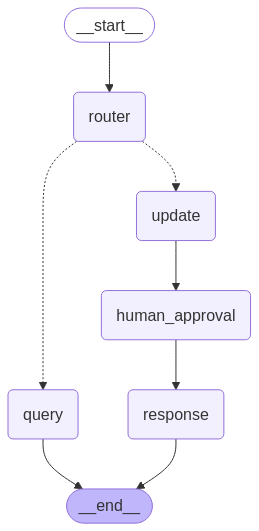

In [32]:
display(Image(account_agent_graph.get_graph().draw_mermaid_png()))

## Test

#### Test fetching account details without providing ID up front

In [33]:
# Input
initial_input = {
    # "messages": [HumanMessage(content="Update my email  address to sid@gmail.com")], 
    # "messages": [HumanMessage(content="Show me my email address")], 
    "messages": [HumanMessage(content="How much money have I spent in total?")], 
    "next_node": NodeType.ROUTER, 
    "customer_id": 2
}

# Thread
thread = {"configurable": {"thread_id": "customer_id_request_4"}}

# Run the graph - it will stop if an interruption occurs
try:
    for event in account_agent_graph.stream(initial_input, thread, stream_mode="values"):
        # Display messages as they come
        event['messages'][-1].pretty_print()
except Exception as e:
    print(f"Graph execution stopped: {e}")

# Check if there was an interruption
state = account_agent_graph.get_state(thread)
if state.tasks and any(task.interrupts for task in state.tasks):
    # Get the interruption message
    interrupt_task = next(task for task in state.tasks if task.interrupts)
    interrupt_message = interrupt_task.interrupts[0].value
    
    print(f"\nAgent needs more information: {interrupt_message}")
    
    # Get customer ID from user
    approval = input("Do you approve (yes/no)")
    
    # Validate input
    if approval == "yes":
        # Update the state with the provided customer ID
        account_agent_graph.update_state(
            thread,
            {
                "messages": state.values["messages"],
                "customer_id": state.values["customer_id"],
                "next_node": state.values["next_node"],
                "approved": True
            }
        )
        
        # Continue the graph execution with the updated state
        for event in account_agent_graph.stream(None, thread, stream_mode="values"):
            event['messages'][-1].pretty_print()
    else:
        print("Not approved")

================================ Human Message =================================

How much money have I spent in total?
================================== Ai Message ==================================

This is a query request. Please retrieve the requested information.
================================== Ai Message ==================================

You have spent a total of $38.52 across your purchases. If you need any more details or assistance, feel free to ask!


#### Test updating account attribute

In [22]:
query_customer_info({"customer_id": 2})

/var/folders/h0/6_6mqq755ks82f6p8nvrzqlr0000gn/T/ipykernel_13907/2998263118.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  query_customer_info({"customer_id": 2})


"[(2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'sid@gmail.com', 5)]"

# New Execution Logic

In [23]:
def run_agent_with_interruption_handling(graph, initial_input, thread_config):
    """
    Run an agent graph with elegant handling of multiple possible interruptions.
    
    Args:
        graph: The compiled LangGraph to run
        initial_input: The initial state to provide to the graph
        thread_config: Thread configuration dictionary
    
    Returns:
        The final response from the graph
    """
    current_input = initial_input
    all_messages = initial_input.get("messages", [])
    
    while True:
        
        for event in graph.stream(current_input, thread_config, stream_mode="values"):

            # Add new messages to our collection and display them
            if 'messages' in event and event['messages']:
                new_messages = [msg for msg in event['messages'] if msg not in all_messages]
                all_messages = event['messages']
                
                for msg in new_messages:
                    msg.pretty_print()

        # Get the state to check for completion or interruption
        state = graph.get_state(thread_config)
        
        # Check if the graph completed execution
        if state.next == ():
            print("\n✅ Graph execution completed successfully")
            return all_messages

        # If we're here, there might be an interruption
        if state.tasks and any(task.interrupts for task in state.tasks):
            # Find the first task with interrupts
            interrupt_task = next(task for task in state.tasks if task.interrupts)
            interrupt_message = interrupt_task.interrupts[0].value
            node_name = interrupt_task.name
            
            print(f"\n⚠️ Graph interrupted at node '{node_name}': {interrupt_message}")
            
            # Handle the interruption based on its type
            interrupt_handler = identify_interrupt_handler(interrupt_message, node_name)
            
            if interrupt_handler:
                # Use the handler to update the state and get new input (if any)
                current_input = interrupt_handler(graph, state, thread_config, interrupt_message)
            else:
                print(f"❌ Unknown interruption type: {interrupt_message}")
                print(state)
                return all_messages
        else:
            # If no tasks with interrupts but graph didn't reach END,
            # something else might be wrong
            print(f"❌ Graph execution stopped unexpectedly")
            print(state.tasks)
            print(state.next)
            return all_messages

def identify_interrupt_handler(interrupt_message, node_name=None):
    """
    Identify the appropriate handler function based on the interruption message.
    
    Args:
        interrupt_message: The message from the interruption
    
    Returns:
        The handler function or None if no matching handler is found
    """
    if interrupt_message == customer_id_interrupt_message:
        return handle_customer_id_interrupt
    elif interrupt_message == action_confirmation_interrupt_message:
        return handle_confirmation_interrupt
    else:
        print(f"!!!!! Unindentified interrupt message {interrupt_message}")
        return handle_generic_interrupt

def handle_customer_id_interrupt(graph, state, thread_config, interrupt_message):
    """Handle interruption requesting customer ID."""
    customer_id_input = input(f"\n🔍 {interrupt_message}")
    
    # Validate input
    if customer_id_input.isdigit():
        # Update the state with the provided customer ID
        new_messages = state.values["messages"] + [
            HumanMessage(content=f"My customer ID is {customer_id_input}")
        ]
        
        graph.update_state(
            thread_config,
            {
                # "customer_id": int(customer_id_input),
                "customer_id": state.values.get("customer_id"),
                "current_mode": state.values.get("current_mode", "account"),
                "messages": new_messages
            }
        )
        
        # No new input needed, just continue with the updated state
        return None
    else:
        print(f"\n🔍 {interrupt_message}. Please enter a valid numeric ID.")
        # Recursively call this handler again
        return handle_customer_id_interrupt(graph, state, thread_config, interrupt_message)

def handle_confirmation_interrupt(graph, state, thread_config, interrupt_message):
    """Handle interruption requesting confirmation for action."""
    confirmation = input(f"\n{interrupt_message} (yes/no): \n").lower()
    
    if confirmation in ("yes", "y"):
        # Add confirmation message to the conversation
        new_messages = state.values["messages"] + [
            HumanMessage(content="Yes, I confirm.")
        ]
        
        graph.update_state(
            thread_config,
            {
                "messages": new_messages,
                "current_mode": state.values.get("current_mode"),
                "customer_id": state.values.get("customer_id")
            }
        )
        return None
    else:
        # Add rejection message to the conversation
        new_messages = state.values["messages"] + [
            HumanMessage(content="No, I don't want to proceed with this.")
        ]
        
        graph.update_state(
            thread_config,
            {
                "messages": new_messages,
                "current_mode": state.values.get("current_mode"),
                "customer_id": state.values.get("customer_id")
            }
        )
        return None

def handle_generic_interrupt(graph, state, thread_config, interrupt_message):
    """Handle any other type of interruption generically."""
    print(f"\n⚠️ {interrupt_message}")
    
    user_response = input(f"\n{interrupt_message} \nYour response: ")
    
    new_messages = state.values["messages"] + [
        HumanMessage(content=user_response)
    ]
    
    graph.update_state(
        thread_config,
        {
            "messages": new_messages,
            "current_mode": state.values.get("current_mode"),
            "customer_id": state.values.get("customer_id")
        }
    )
    return None

In [24]:
# initial_input = {
#     "messages": [HumanMessage(content="I want to update my account email to test@this-1.com")], 
#     "current_mode": "account", 
#     "customer_id": None
# }

# # Define thread
# thread = {"configurable": {"thread_id": "multi_interrupt_demo-16"}}

# # Run with interrupt handling
# final_messages = run_agent_with_interruption_handling(
#     account_agent_graph,
#     initial_input,
#     thread
# )